# a

Merits of reinforced learning:
1. If you do it right you can solve complex issues with fairly small amounts of code.
2. It can run quickly compared to some computational methods of solving problems (like with inverse kinematics).
3. The model can often be self correcting given enough training.

Demerits:
1. It isn't always consistent, depending on how stocastic the environment is.
2. Hyperparameters can be very finicky, and sometimes you can't figure out the "settings" to make something work well
3. In many problems it can be computationally expensive, like when dealing with image data using convolutional neural networks.

# b
![RL vs controls](res\5_diagrams.jpg)

A reinforcement learning model doesn't interpret data the same way as a controller does. While a controller makes measurements of its surroundings, and then acts directly on that information to adjust for bias and make decisions, a RL model is more abstract. It gains rewards for doing something correctly, and slowly trains itself on the environment to make actions that provide more rewards. While this allows for solving much more complex systems, it doesn't provide the same control over the system as a controller does.

In [345]:
%pip install gym[classic_control] --upgrade gym

Note: you may need to restart the kernel to use updated packages.


In [346]:
from IPython.display import HTML
from base64 import b64encode

def show_video(file_name):
    mp4 = open(file_name, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [347]:
import numpy as np
import gym

import matplotlib.pyplot as plt
import seaborn as sns

In [348]:
class Agent(object):
    def __init__(self):
        self.quality_table = np.zeros(shape=(3, 3, 6, 6, 2))

        self.decay = 25
        self.min_randomness = 0.01
        self.min_learning_rate = 0.01
        self.randomness = 0
        self.learning_rate = 0

    def act(self, state):
        if np.random.random() <= self.randomness: # Choose a random action sometimes
            return np.random.randint(0, 2)
        return np.argmax(self.quality_table[state]) # Otherwise, take the best action

    def update(self, state, next_state, action, reward):
        target = reward + np.max(self.quality_table[next_state])

        self.quality_table[state][action] += (
            target - self.quality_table[state][action]
        ) * self.learning_rate

    def update_learning_rate(self, iteration):
        self.learning_rate = max(
            self.min_learning_rate,
            min(1.0, 1.0 - np.log10(iteration / self.decay))
        )
        self.randomness = self.learning_rate

    @staticmethod
    def quantize_state(state):
        return (
            Agent.rescale(state[0], 4.8, -4.8, 3),
            Agent.rescale(state[1], 1.0, -1.0, 3),
            Agent.rescale(state[2], 0.418, -0.418, 6),
            Agent.rescale(state[3], 1.0, -1.0, 6)
        )

    @staticmethod
    def rescale(x, high, low, buckets):
        x = ((x + abs(low)) / (high - low))
        x = int(round((buckets - 1) * x))
        x = min(buckets - 1, max(0, x))
        return x


In [349]:
max_iteration = 500
logging_iteration = 50

environment = gym.wrappers.RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda x: x % (logging_iteration*2) == 0
)

agent = Agent()
learning = []

for iteration in range(1, max_iteration + 1):
    steps = 0
    running = True
    state = environment.reset()
    state_array, _ = state
    state = Agent.quantize_state(state_array)

    agent.update_learning_rate(iteration)

    while running:
        steps += 1
        action = agent.act(state)
        next_state, reward, done, *_ = environment.step(action)

        next_state = Agent.quantize_state(next_state)
        agent.update(state, next_state, action, reward)
        state = next_state

        if done: # This is supposed to have a cap at 500 but for some reason it is going longer
            running = False

    learning.append(steps)
    if iteration % logging_iteration == 0:
        print(f"Iteration: {iteration} | Moving-Average Steps: {np.mean(learning[-logging_iteration:]):.4f}")

c:\Users\Jonathan\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-1500.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-1500.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-1500.mp4
Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-0.mp4
Iteration: 50 | Moving-Average Steps: 23.0800
Iteration: 100 | Moving-Average Steps: 35.3000
Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-100.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-100.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-100.mp4


Iteration: 150 | Moving-Average Steps: 72.3600
Iteration: 200 | Moving-Average Steps: 133.1200
Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-200.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-200.mp4
Iteration: 250 | Moving-Average Steps: 284.8800
Iteration: 300 | Moving-Average Steps: 854.5800
Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-300.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-300.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-300.mp4
Iteration: 350 | Moving-Average Steps: 1568.0800
Iteration: 400 | Moving-Average Steps: 1530.1400
Moviepy - Building video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-400.mp4.
Moviepy - Writing video c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-400.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Jonathan\Documents\GitHub\CS5510-Robot-Intelligence\videos\rl-video-episode-400.mp4
Iteration: 450 | Moving-Average Steps: 1516.9000
Iteration: 500 | Moving-Average Steps: 1586.4400


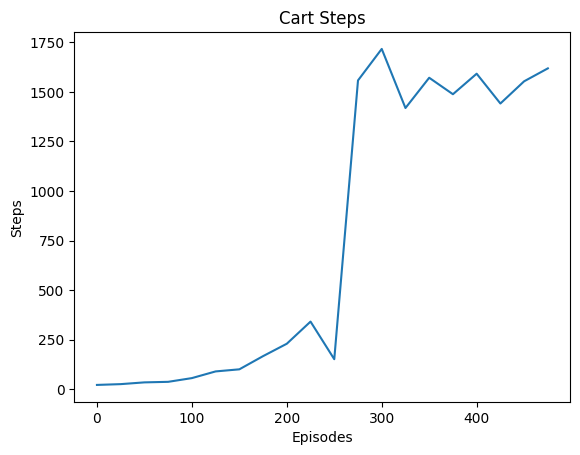

In [350]:
x = np.arange(0, len(learning), 25)
y = np.add.reduceat(learning, x) / 25

sns.lineplot(x=x, y=y)
plt.title("Cart Steps")
plt.xlabel("Episodes")
plt.ylabel("Steps")
plt.show()

In [351]:
display(show_video("./videos/rl-video-episode-0.mp4"))
display(show_video("./videos/rl-video-episode-600.mp4"))